## Load the data in pickle file 

In [1]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [2]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


### Load the real observations

In [3]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

# Preprocessing of the data: $(x_{i,t,m}^{p})_{i=1,\ldots,I, t=1,\ldots,T,m=1,\ldots,M, p=1,\ldots,d}$
## $i$: ensemble member (run) index
## $t$: time index
## $m$: model index
## $p$: grid cell index

#### Keep the model with at least 3 ensemble memebers and downscale the data from latitude 144 -> 36 with local averaging (to match with ensemble methods

In [4]:
import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))

### 1) Compute anomalies: $\displaystyle \overline{x}_{i,t,m}^p = x_{i,t,m}^p - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \sum_{i=1}^I x_{i,t,m}^p$

In [5]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
        else:
            mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = dic_processed_ssp585[m][i] - mean_ref_ensemble


/tmp/ipykernel_5593/4168053547.py:13: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
/tmp/ipykernel_5593/4168053547.py:15: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])


### 2) Compute the forced response: 
#### - Mean over space: $\displaystyle y_{i,t,m} = \frac{1}{P} \sum_{p=1}^P x_{i,t,m}^p$
#### - Mean over ensemble members: $\displaystyle \overline{y}_{t,m} = \frac{1}{I} \sum_{i=1}^I y_{i,t,m}$
#### - Set the mean to all the ensemble member forced responses: $y_{i,t,m} \colon= \overline{y}_{t,m}$
#### - Centering with respect to a given reference period: $\displaystyle y_{i,t,m} = y_{i,t,m} - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \overline{y}_{t,m}$

In [6]:
# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_spatial_ensemble = 0
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
        else:
            mean_spatial_ensemble += np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
            
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.mean(mean_spatial_ensemble[131:164])

## Now we can use the data to run some simple regression models

In [7]:
time_period = 33
grid_lat_size = 36
grid_lon_size = 72

In [8]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = 0
    x_predictor[m] = 0
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        if idx_i ==0:
            y_forced_response[m] = dic_forced_response_ssp585[m][i][131:164]
            x_predictor[m] = dic_processed_ssp585[m][i][131:164,:,:]
        else:
            y_forced_response[m] = np.concatenate([y_forced_response[m],dic_forced_response_ssp585[m][i][131:164]])
            x_predictor[m] = np.concatenate([x_predictor[m], dic_processed_ssp585[m][i][131:164,:,:]],axis=0)        

In [9]:
# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    arr_tmp = np.zeros((len(dic_processed_ssp585[m].keys()),33))
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        arr_tmp[idx_i,:] = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=(1,2))
    variance_processed_ssp585[m] = np.mean(np.var(arr_tmp,axis=0))
    std_processed_ssp585[m] = np.mean(np.std(arr_tmp,axis=0))

### Define optimizaton problem with Pytorch

In [10]:
import torch 

# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = torch.from_numpy(np.nan_to_num(x_predictor[m]).reshape(x_predictor[m].shape[0],x_predictor[m].shape[1]*x_predictor[m].shape[2])).to(torch.float64)
    y_train[m] = torch.from_numpy(np.nan_to_num(y_forced_response[m])).to(torch.float64)

    nans_idx = np.where(np.isnan(x_predictor[m][0,:,:].ravel()))[0]

In [28]:
def ridge_estimator(model_out,x,y,vars,lambda_):
    """
    Compute the ridge estimator given gammas.
    """
    idx_start = 0
    for idx_m,m in enumerate(list(x.keys())):
        if m!= model_out:
            if idx_start==0:
                X_tmp = x[m]
                y_tmp = y[m]
                D = (1/vars[m])*torch.eye(x[m].shape[0])
                idx_start +=1
            else:
                X_tmp = torch.cat((X_tmp,x[m]),0)
                y_tmp = torch.cat((y_tmp,y[m]),0)
                D_tmp = ((1/vars[m]) * torch.eye(x[m].shape[0])).to(torch.float64)
                D = torch.block_diag(D, D_tmp).to(torch.float64)

    A = torch.matmul(torch.matmul(X_tmp.T, D),X_tmp) + lambda_ * torch.eye(X_tmp.shape[1])
    b = torch.matmul(torch.matmul(X_tmp.T,D),y_tmp)
    
    return torch.linalg.solve(A,b)

In [39]:
def train_ridge_regression(model_out,x,y,vars,lon_size,lat_size,lambda_,nbEpochs=100,verbose=True):
    """
    Given a model m, learn parameter β^m such that β^m = argmin_{β}(||y_m - X_m^T β||^2) ).

    Args:
        - x, y: training set and training target 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - lambda_: regularizer coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    beta = torch.zeros(lat_size*lon_size).to(torch.float64)
    beta.requires_grad_(True)  
                          
    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-3)
            
    # --- optimization loop ---                
    for epoch in torch.arange(nbEpochs):      
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
                    
        # first term: ||Y - X - Rb ||
        obj =0.0
        for idx_m,m in enumerate(x.keys()):
            if m != model_out:
                
                obj += torch.mean((y[m] - torch.matmul(x[m],beta))**2/vars[m])
        obj += lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj
                    
        # Use autograd to compute the backward pass. 
        loss.backward(retain_graph=True)               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()       
        
        if(verbose==True):
            if(epoch % 10 == 0):
                print('Epoch ', epoch.detach().item(), 
                    ', loss=', loss.detach().item()
                    )
    return beta.detach().clone()

In [30]:
def train_robust_model(x,y,vars,lon_size,lat_size,models,alpha_,lambda_,nbEpochs,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_m exp(||y_m - X_m^T β||^2) ).

    Args:
        - x: 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - models: (sub)list of models (list)
        - alpha_: softmax coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    beta = torch.zeros(grid_lat_size*grid_lon_size).to(torch.float64)
    beta.requires_grad_(True)  
                          
    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-3)
            
    # --- optimization loop ---                
    for epoch in torch.arange(nbEpochs):      
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
                    
        # first term: ||Y - X - Rb ||
        obj = torch.tensor(0.0)
        for idx_m,m in enumerate(x.keys()):
            obj += torch.exp((1/alpha_)*torch.mean((y[m] - torch.matmul(x[m],beta))**2)/variance_processed_ssp585[m])
    
        obj = alpha_*torch.log(obj)

        obj += lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj
                    
        # Use autograd to compute the backward pass. 
        loss.backward(retain_graph=True)               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()       
        
        if(verbose==True):
            if(epoch % 10 == 0):
                print('Epoch ', epoch.detach().item(), 
                    ', loss=', loss.detach().item()
                    )
    return beta.detach().clone()

In [42]:
alpha_ = 0.2
lambda_ = 10
selected_models = list(dic_reduced_ssp585.keys())

# beta_robust = train_robust_model(x_train,y_train,variance_processed_ssp585,\
#                           grid_lat_size,grid_lon_size,\
#                           selected_models,alpha_,lambda_,nbEpochs=1000,verbose=True)

# beta_ridge = ridge_estimator(selected_models[0],x_train,y_train,variance_processed_ssp585,lambda_)

beta_ridge = train_ridge_regression(selected_models[0],x_train,y_train,variance_processed_ssp585,\
                                    grid_lat_size,grid_lon_size,\
                                    lambda_,nbEpochs=100,verbose=True)

Epoch  0 , loss= 123.78940752089224
Epoch  10 , loss= 41.74453649809148
Epoch  20 , loss= 16.517971738782624
Epoch  30 , loss= 10.06697181724254
Epoch  40 , loss= 10.248566579119535
Epoch  50 , loss= 9.041820781614318
Epoch  60 , loss= 8.769283239738746
Epoch  70 , loss= 8.396837833519143
Epoch  80 , loss= 8.204328817950174
Epoch  90 , loss= 8.05148388030821


In [ ]:
# # define beta to plot
# beta_softmax_tmp = beta_robust.detach().clone()
# beta_softmax_tmp[nans_idx] = 1e5
# beta_softmax = beta_softmax_tmp.detach().numpy().reshape(lat.shape[0],lon.shape[0])

# fig0 = plt.figure(figsize=(16,16))           

# ax0 = fig0.add_subplot(2, 2, 1)        
# ax0.set_title('Observations', size=7,pad=3.0)
# im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_softmax,vmin=-0.00,vmax = 0.005)
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)


# plt.show()

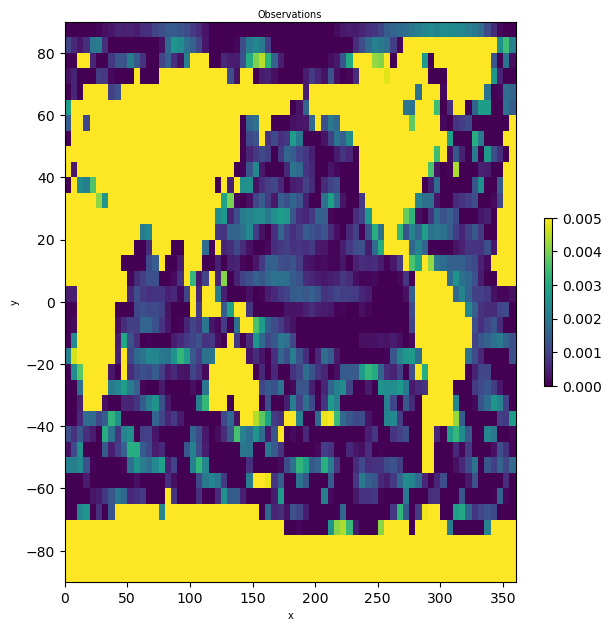

In [43]:
# define beta to plot
beta_softmax_tmp = beta_ridge.detach().clone()
beta_softmax_tmp[nans_idx] = 1e5
beta_softmax = beta_softmax_tmp.detach().numpy().reshape(lat.shape[0],lon.shape[0])

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title('Observations', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_softmax,vmin=-0.00,vmax = 0.005)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)


plt.show()

### plot the softmax coefficients

In [ ]:
# compute the coefficient using soft max
# M = len(list(dic_reduced_ssp585.keys()))
# gamma = torch.zeros(M)

# for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
#     gamma[idx_m] = torch.exp((1/alpha_)*torch.mean((y_train[m] - torch.matmul(x_train[m],beta_robust))**2/variance_processed_ssp585[m]))

# gamma = gamma/torch.sum(gamma)

# # plot the model contributions
# fig, ax = plt.subplots()
# models = list(dic_reduced_ssp585.keys())
# weights = list(gamma.detach().numpy())

# ax.bar(models, weights,label='Model weights')
# ax.set_ylabel(r'weights $\gamma$')
# ax.set_title('cmip6 models')
# ax.legend()
# ax.set_xticklabels(models, rotation=-90)
# plt.tight_layout()
# plt.show()

In [156]:
# alpha_ = torch.tensor(1.0)
# lambda_ = torch.tensor(1.0)
# weights = compute_weights(m,x_train,y_train,variance_processed_ssp585,beta_robust,grid_lon_size,grid_lat_size,alpha_,lambda_)

## Leave-one-out procedure

In [157]:
def compute_weights(m,x,y,vars,beta,lon_size,lat_size,alpha_,lambda_):
    """
    Plot and return the weights of the robust model.
    """
    
    # compute the coefficient using soft max
    M = len(list(x.keys()))
    gamma = np.zeros(M)
    beta_tmp = beta.detach().numpy()
    
    for idx_m,m_it in enumerate(x.keys()):
        if m_it != m:
            gamma[idx_m] = np.exp((1/alpha_)*np.mean((y[m_it].numpy() - np.dot(x[m_it].numpy(),beta_tmp))**2/vars[m_it]))
    
    gamma = gamma/np.sum(gamma)
    
    # plot the model contributions
    models = list(vars.keys())
    weights = {m: gamma[idx_m].item() for idx_m,m in enumerate(x.keys())}

    return weights

In [28]:
def leave_one_out(model_out,x,y,vars,lon_size,lat_size,alpha_,lambda_,nbEpochs=500,verbose=True):

    # Data preprocessing
    x_train = {}
    y_train = {}
    selected_models = []

    for idx_m,m in enumerate(x.keys()):
        if m != model_out:

            selected_models.append(m)
            
            x_train[m] = torch.from_numpy(np.nan_to_num(x[m]).reshape(x[m].shape[0],x[m].shape[1]*x[m].shape[2])).to(torch.float64)
            y_train[m] = torch.from_numpy(np.nan_to_num(y[m])).to(torch.float64)
        
            nans_idx = np.where(np.isnan(x[m][0,:,:].ravel()))[0]

        else:
            x_test = np.nan_to_num(x[m]).reshape(x[m].shape[0],x[m].shape[1]*x[m].shape[2])            
            y_test = np.nan_to_num(y[m])


    beta_robust = train_robust_model(x_train,y_train,vars,\
                                      lon_size,lat_size,\
                                      selected_models,alpha_,lambda_,nbEpochs,verbose)

    
    y_pred = np.dot(x_test,beta_robust)

    weights = compute_weights(model_out,x_train,y_train,vars,beta_robust,lon_size,lat_size,alpha_,lambda_)


    return beta_robust, y_pred, y_test, weights

In [183]:
def leave_one_out_procedure(x,y,vars,lon_size,lat_size,alpha_,lambda_,nbEpochs=500,verbose=True):

    beta_robust = {}
    y_pred = {}
    y_test = {}
    rmse = {}
    weights = {m: 0.0 for idx_m, m in enumerate(x.keys())}
    
    for idx_m, m in enumerate(x.keys()):
        beta_robust[m], y_pred[m], y_test[m], weights_tmp = leave_one_out(m,x,y,vars,lon_size,lat_size,alpha_,lambda_,nbEpochs,verbose)
        rmse[m] =  np.mean((y_test[m] - y_pred[m])**2)

        # compute the weight when a single model is out 
        for m_tmp in list(x.keys()):
            if m_tmp != m:
                weights[m_tmp] += (1/(len(x.keys())-1))* weights_tmp[m_tmp]

        # print the rmse
        print('RMSE on model ', m, ' : ', np.mean((y_pred[m] - y_test[m])**2))

    # create the function y=x
    minx = np.min(y_test[m])
    maxx = np.max(y_test[m])
    x_tmp = np.linspace(minx,maxx,100)
    y_tmp = x_tmp

    ################# plot the observation vs prediction accuracy #####################################
    fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    axs = axs.ravel()
    
    for idx_m, m in enumerate(x.keys()):

        axs[idx_m].scatter(y_test[m],y_pred[m],label=m,s=0.1)
        axs[idx_m].plot(x_tmp,y_tmp,color='r',linewidth=0.5)
        axs[idx_m].set_title(m)

    for i in range(len(x.keys()),30):
        fig.delaxes(axs[i])

    fig.tight_layout()
    plt.savefig("results/pred_vs_real_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()

    ############################### plot the residuals #####################################
    fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    axs = axs.ravel()
    
    for idx_m, m in enumerate(x.keys()):

        axs[idx_m].scatter(y_test[m],y_test[m] - y_pred[m],label=m,s=0.1)
        axs[idx_m].plot(x_tmp,np.zeros_like(x_tmp),color='r',linewidth=0.5)
        axs[idx_m].set_title(m)

    for i in range(len(x.keys()),30):
        fig.delaxes(axs[i])

    fig.tight_layout()
    plt.savefig("results/residuals_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()
    
    ############## plot the beta map for each leave-one-out run #####################################
    fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    axs = axs.ravel()
    
    for idx_m, m in enumerate(x.keys()):
        
        beta_robust_tmp = beta_robust[m].detach().clone()
        beta_robust_tmp[nans_idx] = 1e5
        beta_robust_tmp = beta_robust_tmp.detach().numpy().reshape(lat_size,lon_size)

        axs[idx_m].set_title(m)
        im0 = axs[idx_m].pcolormesh(lon_grid,lat_grid,beta_robust_tmp,vmin=-0.00,vmax = 0.005)

    plt.colorbar(im0, ax=axs[idx_m], shrink=0.5)

    for i in range(len(x.keys()),30):
        fig.delaxes(axs[i])

    fig.tight_layout()
    plt.savefig("results/beta_map_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()

    
    ################# plot the weights #################
    fig, ax = plt.subplots()
    models = list(x.keys()) 
    weights_plot = list(weights.values()) 
    ax.bar(models, weights_plot,label='Model weights')
    ax.set_ylabel(r'weights $\gamma$')
    ax.set_title('cmip6 models')
    ax.legend()
    ax.set_xticklabels(models, rotation=-90)
    plt.tight_layout()
    plt.savefig("results/weights_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()
    

    return beta_robust, rmse, weights

In [45]:
def leave_one_out_ridge(model_out,x,y,vars,lon_size,lat_size,lambda_):

    # Data preprocessing
    x_train = {}
    y_train = {}
    selected_models = []

    for idx_m,m in enumerate(x.keys()):
        if m != model_out:

            selected_models.append(m)
            
            x_train[m] = torch.from_numpy(np.nan_to_num(x[m]).reshape(x[m].shape[0],x[m].shape[1]*x[m].shape[2])).to(torch.float64)
            y_train[m] = torch.from_numpy(np.nan_to_num(y[m])).to(torch.float64)
        
            nans_idx = np.where(np.isnan(x[m][0,:,:].ravel()))[0]

        else:
            x_test = np.nan_to_num(x[m]).reshape(x[m].shape[0],x[m].shape[1]*x[m].shape[2])            
            y_test = np.nan_to_num(y[m])


    beta_ridge = train_ridge_regression(model_out,x_train,y_train,vars,\
                                    lon_size,lat_size,\
                                    lambda_,nbEpochs=100,verbose=True)
    
    y_pred = np.dot(x_test,beta_ridge)

    return beta_ridge, y_pred, y_test

In [48]:
def leave_one_out_procedure_ridge(x,y,vars,lon_size,lat_size,lambda_):

    beta_ridge = {}
    y_pred = {}
    y_test = {}
    rmse = {}
    weights = {m: 0.0 for idx_m, m in enumerate(x.keys())}
    
    for idx_m, m in enumerate(x.keys()):
        
        beta_ridge[m], y_pred[m], y_test[m] = leave_one_out_ridge(m,x,y,vars,lon_size,lat_size,lambda_)
        rmse[m] =  np.mean((y_test[m] - y_pred[m])**2)

        # print the rmse
        print('RMSE on model ', m, ' : ', np.mean((y_pred[m] - y_test[m])**2))

    # create the function y=x
    minx = np.min(y_test[m])
    maxx = np.max(y_test[m])
    x_tmp = np.linspace(minx,maxx,100)
    y_tmp = x_tmp

    ################# plot the observation vs prediction accuracy #####################################
    fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    axs = axs.ravel()
    
    for idx_m, m in enumerate(x.keys()):

        axs[idx_m].scatter(y_test[m],y_pred[m],label=m,s=0.1)
        axs[idx_m].plot(x_tmp,y_tmp,color='r',linewidth=0.5)
        axs[idx_m].set_title(m)

    for i in range(len(x.keys()),30):
        fig.delaxes(axs[i])

    fig.tight_layout()
    plt.savefig("results/pred_vs_real_ridge_"+str(lambda_)+".eps", dpi=150)
    plt.show()

    ############################### plot the residuals #####################################
    fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    axs = axs.ravel()
    
    for idx_m, m in enumerate(x.keys()):

        axs[idx_m].scatter(y_test[m],y_test[m] - y_pred[m],label=m,s=0.1)
        axs[idx_m].plot(x_tmp,np.zeros_like(x_tmp),color='r',linewidth=0.5)
        axs[idx_m].set_title(m)

    for i in range(len(x.keys()),30):
        fig.delaxes(axs[i])

    fig.tight_layout()
    plt.savefig("results/residuals_ridge_"+str(lambda_)+".eps", dpi=150)
    plt.show()
    
    ############## plot the beta map for each leave-one-out run #####################################
    fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    axs = axs.ravel()
    
    for idx_m, m in enumerate(x.keys()):
        
        beta_ridge_tmp = beta_ridge[m].detach().clone()
        beta_ridge_tmp[nans_idx] = 1e5
        beta_ridge_tmp = beta_ridge_tmp.detach().numpy().reshape(lat_size,lon_size)

        axs[idx_m].set_title(m)
        im0 = axs[idx_m].pcolormesh(lon_grid,lat_grid,beta_ridge_tmp,vmin=-0.00,vmax = 0.005)

    plt.colorbar(im0, ax=axs[idx_m], shrink=0.5)

    for i in range(len(x.keys()),30):
        fig.delaxes(axs[i])

    fig.tight_layout()
    plt.savefig("results/beta_ridge_map_"+str(lambda_)+".eps", dpi=150)
    plt.show()
    

    return beta_ridge, rmse

Epoch  0 , loss= 123.78940752089224
Epoch  10 , loss= 41.74453649809148
Epoch  20 , loss= 16.517971738782624
Epoch  30 , loss= 10.06697181724254
Epoch  40 , loss= 10.248566579119535
Epoch  50 , loss= 9.041820781614318
Epoch  60 , loss= 8.769283239738746
Epoch  70 , loss= 8.396837833519143
Epoch  80 , loss= 8.204328817950174
Epoch  90 , loss= 8.05148388030821
RMSE on model  CanESM5-1  :  0.0030288692496895854
Epoch  0 , loss= 133.3895188845747
Epoch  10 , loss= 45.06722861134743
Epoch  20 , loss= 17.481527140395425
Epoch  30 , loss= 10.269394624564425
Epoch  40 , loss= 10.594347615768875
Epoch  50 , loss= 9.468786663237648
Epoch  60 , loss= 9.156385161616804
Epoch  70 , loss= 8.795101505221304
Epoch  80 , loss= 8.620079918157474
Epoch  90 , loss= 8.466341768577516
RMSE on model  CNRM-ESM2-1  :  0.002568524357934378
Epoch  0 , loss= 122.2088349140619
Epoch  10 , loss= 41.757354229927905
Epoch  20 , loss= 16.203503714728782
Epoch  30 , loss= 9.97358125705978
Epoch  40 , loss= 10.369453318

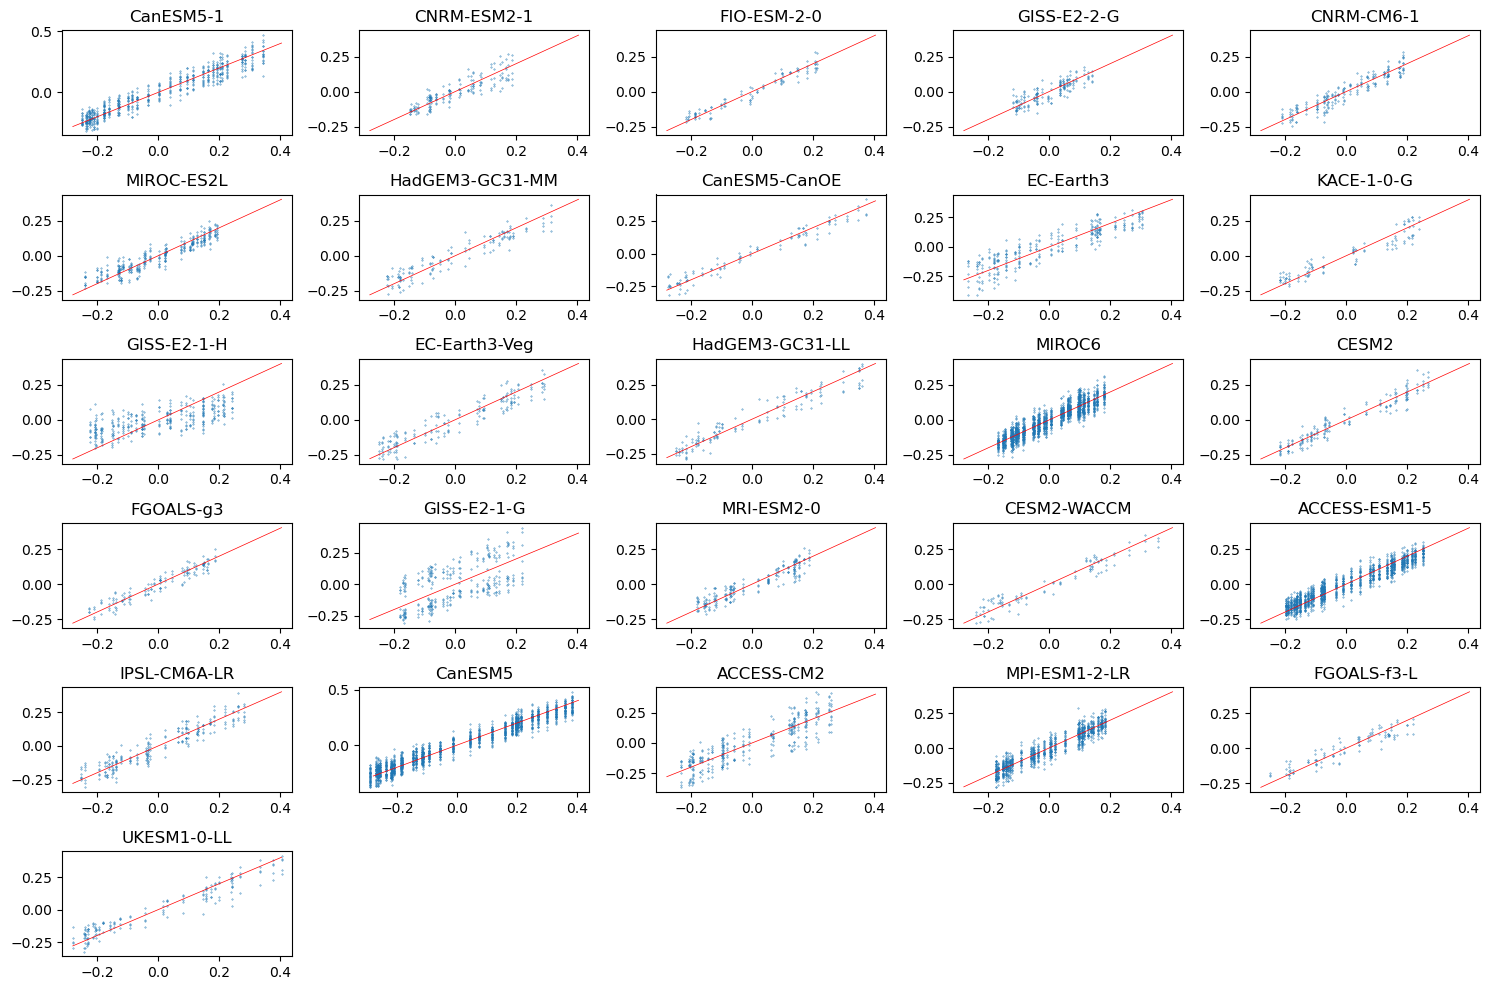

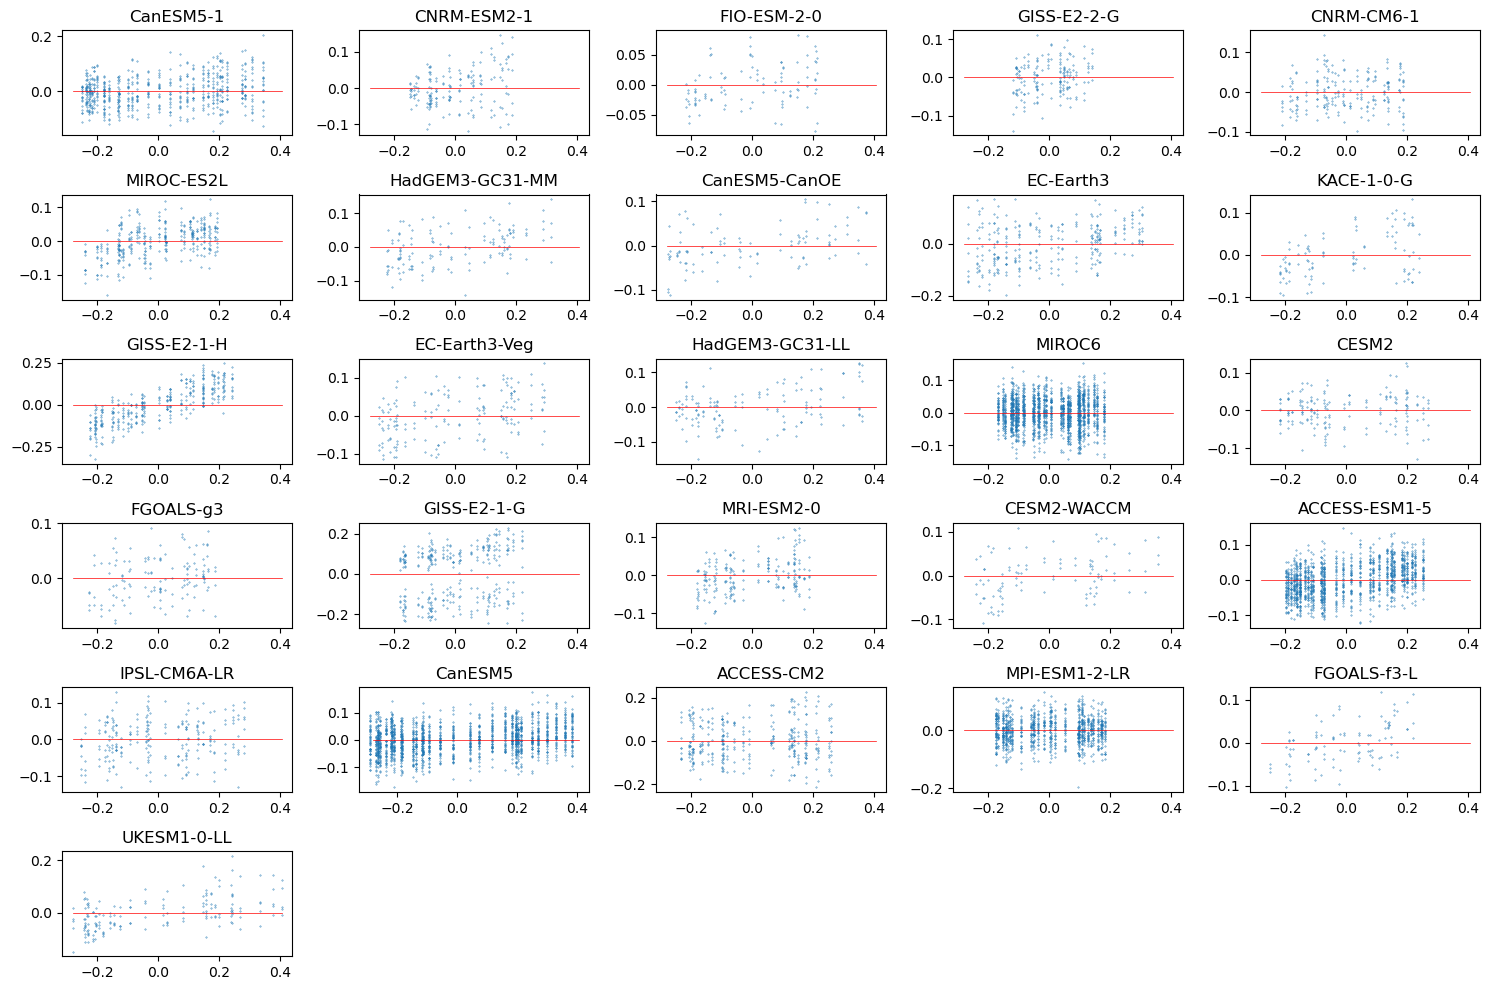

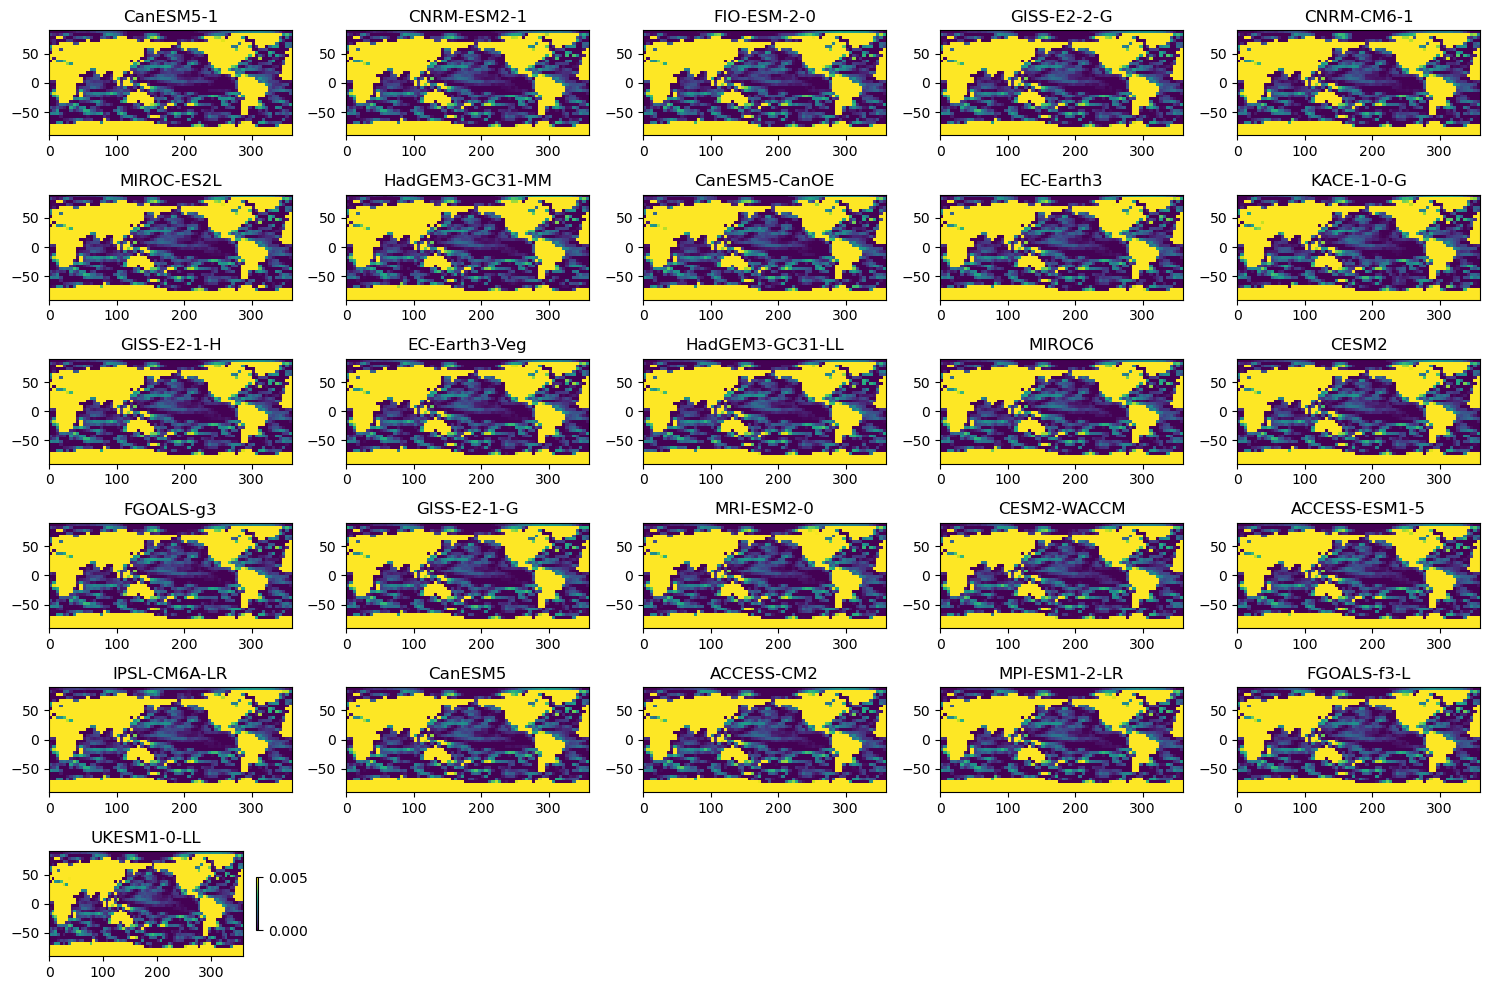

In [49]:
beta_ridge, rmse = leave_one_out_procedure_ridge(x_predictor,y_forced_response,variance_processed_ssp585,\
                                                            grid_lon_size,grid_lat_size,10.0)

In [66]:
def cross_validation_loo(x,y,vars,lon_size,lat_size,\
                         alpha_range,lambda_range,\
                         nbEpochs=500,verbose=True):

    # create the pytorch tensor 
    beta_robust = {}
    rmse = {}
    weights = {}
    y_pred = {}
    y_test = {}
    
   
    # for each pair (alpha, lambda)
    for idx_alpha, alpha_ in enumerate(alpha_range):

        # for each lambda:
        for idx_lambda, lambda_ in enumerate(lambda_range):

            print("Cross validation: (" + str(alpha_)+", "+ str(lambda_)+ ")")

            beta_robust_tmp, rmse_tmp, weights_tmp = leave_one_out_procedure(x,y,vars,lon_size,lat_size,alpha_,lambda_,nbEpochs=500,verbose=False)

            beta_robust[(alpha_,lambda_)] = beta_robust_tmp
            rmse[(alpha_,lambda_)] = rmse_tmp
            weights[(alpha_,lambda_)] = weights_tmp

    return beta_robust, rmse, weights

In [69]:
def cross_validation_loo_ridge(x,y,vars,lon_size,lat_size,lambda_range):

    # create the pytorch tensor 
    beta = {}
    rmse = {}
    weights = {}
    y_pred = {}
    y_test = {}
    
   
    for idx_lambda, lambda_ in enumerate(lambda_range):

        print("Cross validation: ("+ str(lambda_)+ ")")

        beta_ridge_tmp, rmse_tmp = leave_one_out_procedure_ridge(x,y,vars,lon_size,lat_size,lambda_)

        beta[lambda_] = beta_ridge_tmp
        rmse[lambda_] = rmse_tmp

    return beta, rmse

Cross validation: (0.01)
RMSE on model  CanESM5-1  :  0.0044696132660231565
RMSE on model  CNRM-ESM2-1  :  0.0023384883464150664
RMSE on model  FIO-ESM-2-0  :  0.001879045141964832
RMSE on model  GISS-E2-2-G  :  0.0031270066251043982
RMSE on model  CNRM-CM6-1  :  0.0021185445461787823
RMSE on model  MIROC-ES2L  :  0.0029867460657718578
RMSE on model  HadGEM3-GC31-MM  :  0.004539863100837149
RMSE on model  CanESM5-CanOE  :  0.0015097012737903997
RMSE on model  EC-Earth3  :  0.005232110320338152
RMSE on model  KACE-1-0-G  :  0.004200617838063844
RMSE on model  GISS-E2-1-H  :  0.010828432350041049
RMSE on model  EC-Earth3-Veg  :  0.002592710907814113
RMSE on model  HadGEM3-GC31-LL  :  0.0029876389478164164
RMSE on model  MIROC6  :  0.0030852707858222625
RMSE on model  CESM2  :  0.0023861126914394063
RMSE on model  FGOALS-g3  :  0.0023858603106451013
RMSE on model  GISS-E2-1-G  :  0.01467853624721084
RMSE on model  MRI-ESM2-0  :  0.0056565766315198026
RMSE on model  CESM2-WACCM  :  0.00291

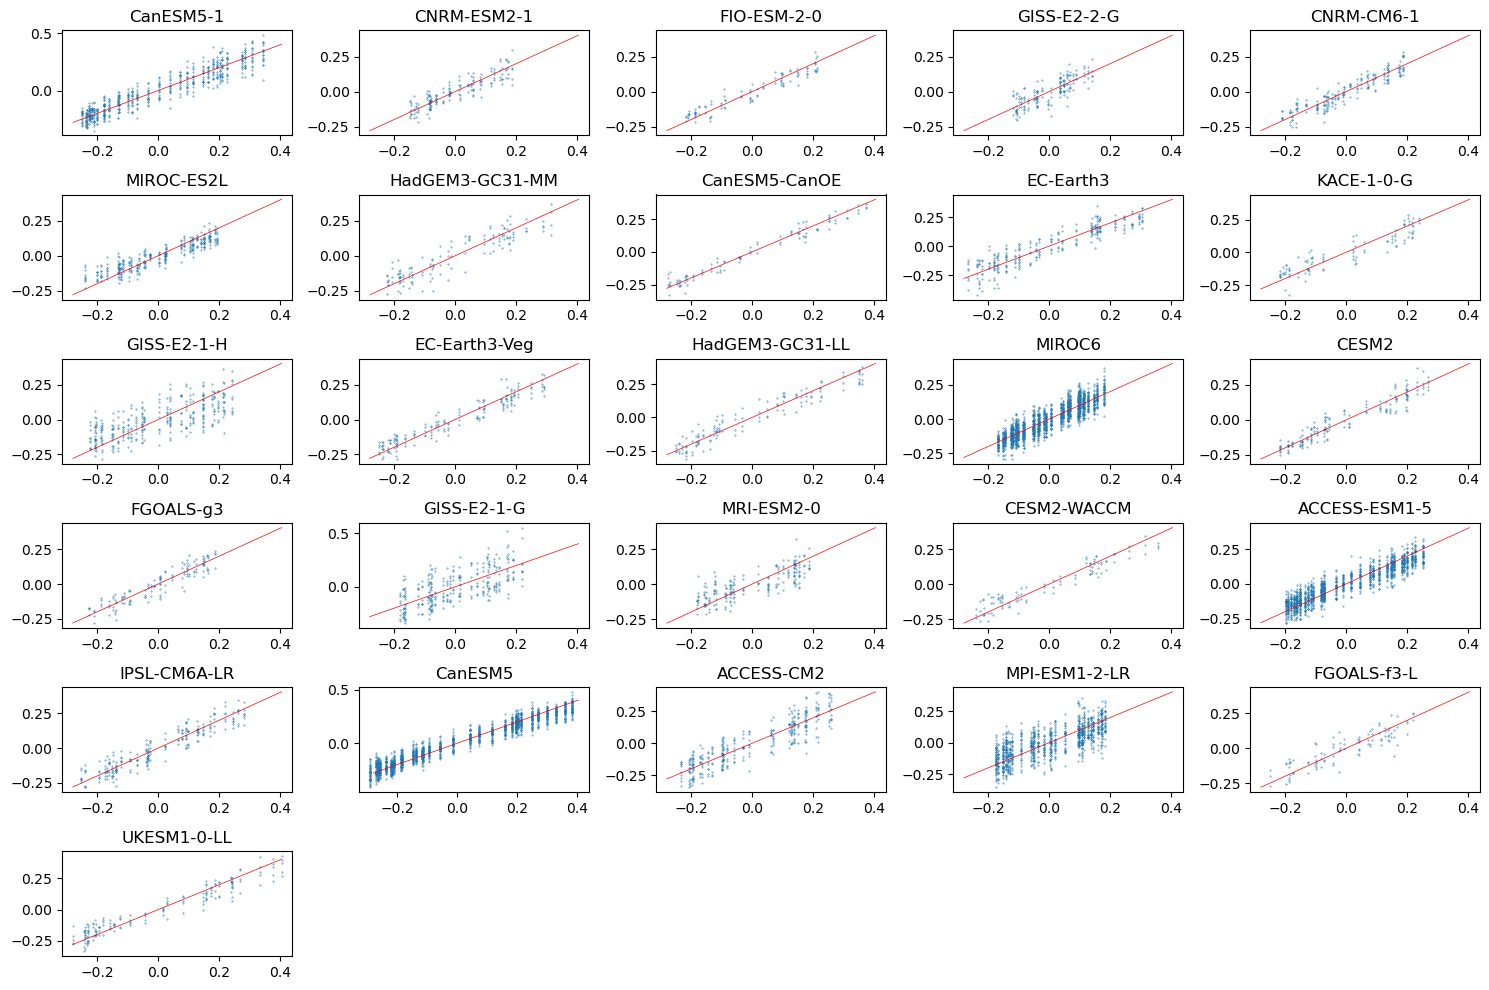

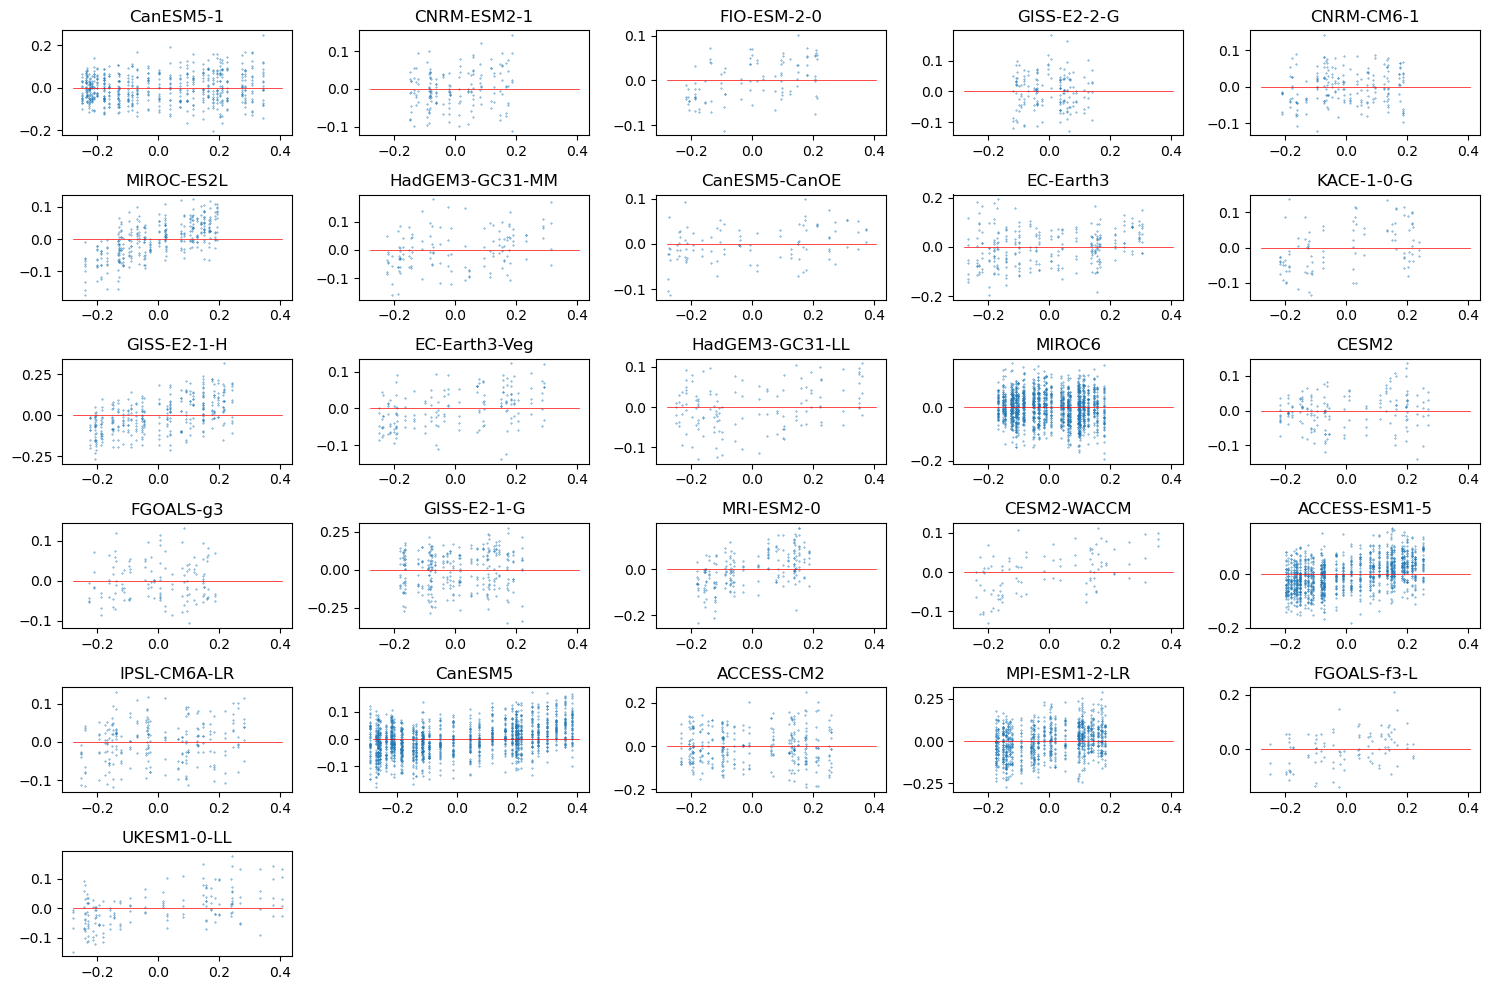

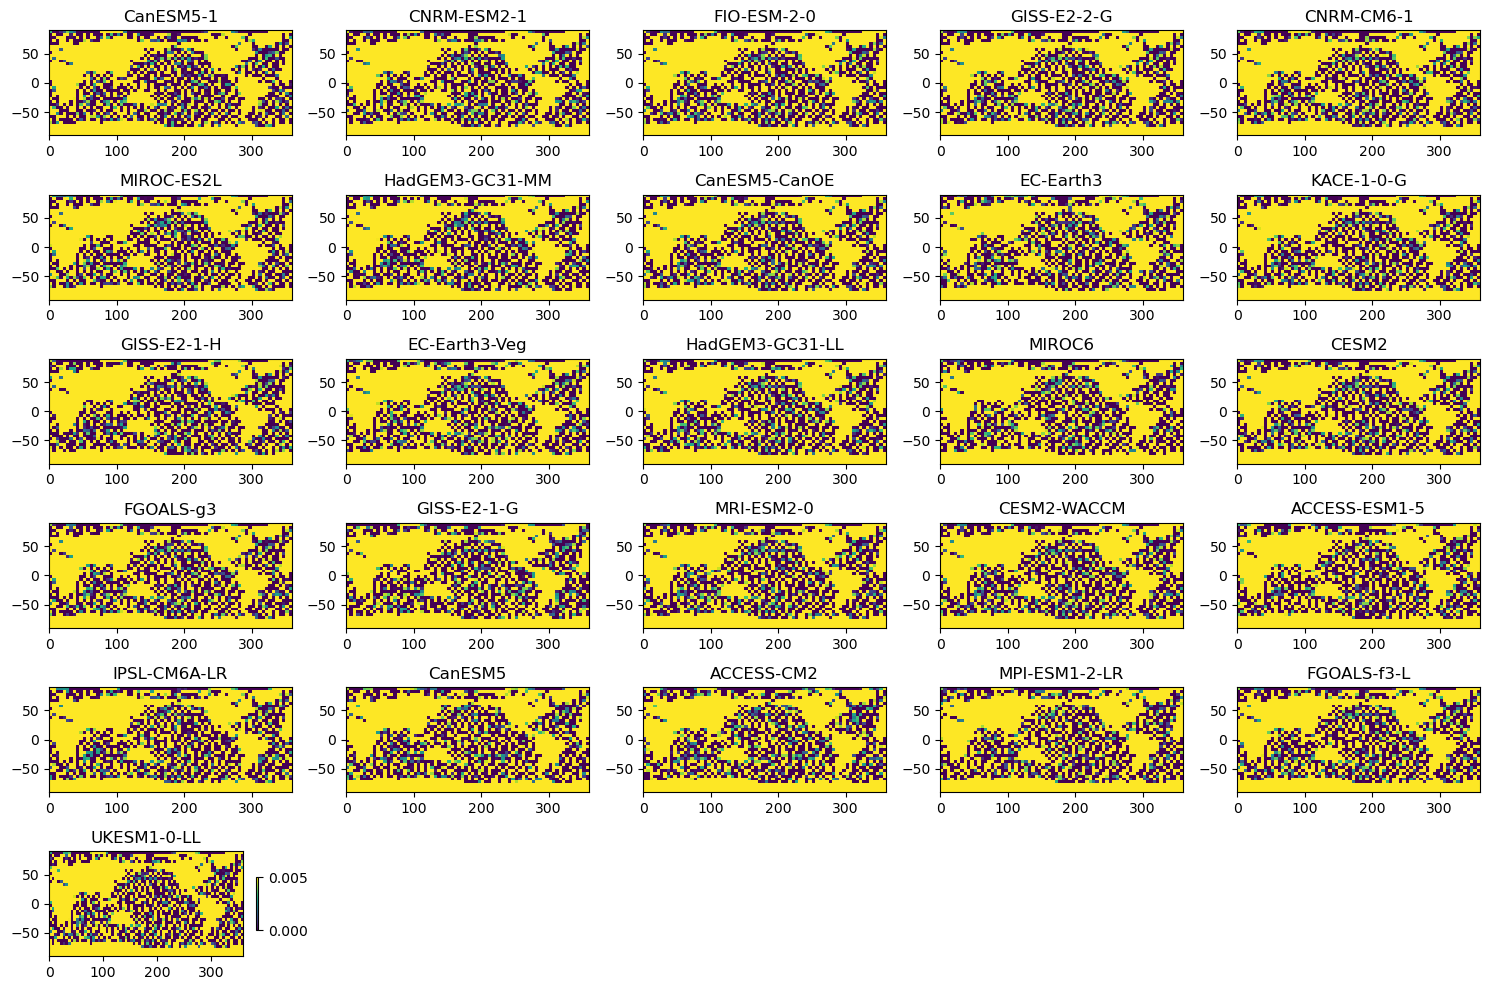

Cross validation: (0.05)
RMSE on model  CanESM5-1  :  0.004364169189172103
RMSE on model  CNRM-ESM2-1  :  0.0023477891764396752
RMSE on model  FIO-ESM-2-0  :  0.0017871622528058972
RMSE on model  GISS-E2-2-G  :  0.002576917099552425
RMSE on model  CNRM-CM6-1  :  0.0019820316577390906
RMSE on model  MIROC-ES2L  :  0.00283751737837292
RMSE on model  HadGEM3-GC31-MM  :  0.003856038304029794
RMSE on model  CanESM5-CanOE  :  0.0015041136265982848
RMSE on model  EC-Earth3  :  0.005069107462283553
RMSE on model  KACE-1-0-G  :  0.0041817740243046
RMSE on model  GISS-E2-1-H  :  0.009528230018060531
RMSE on model  EC-Earth3-Veg  :  0.00254767490295214
RMSE on model  HadGEM3-GC31-LL  :  0.0028408884693086963
RMSE on model  MIROC6  :  0.002949872310329354
RMSE on model  CESM2  :  0.002299166229145686
RMSE on model  FGOALS-g3  :  0.0021026029012157304
RMSE on model  GISS-E2-1-G  :  0.014863652644358622
RMSE on model  MRI-ESM2-0  :  0.004608334669203534
RMSE on model  CESM2-WACCM  :  0.0029529470089

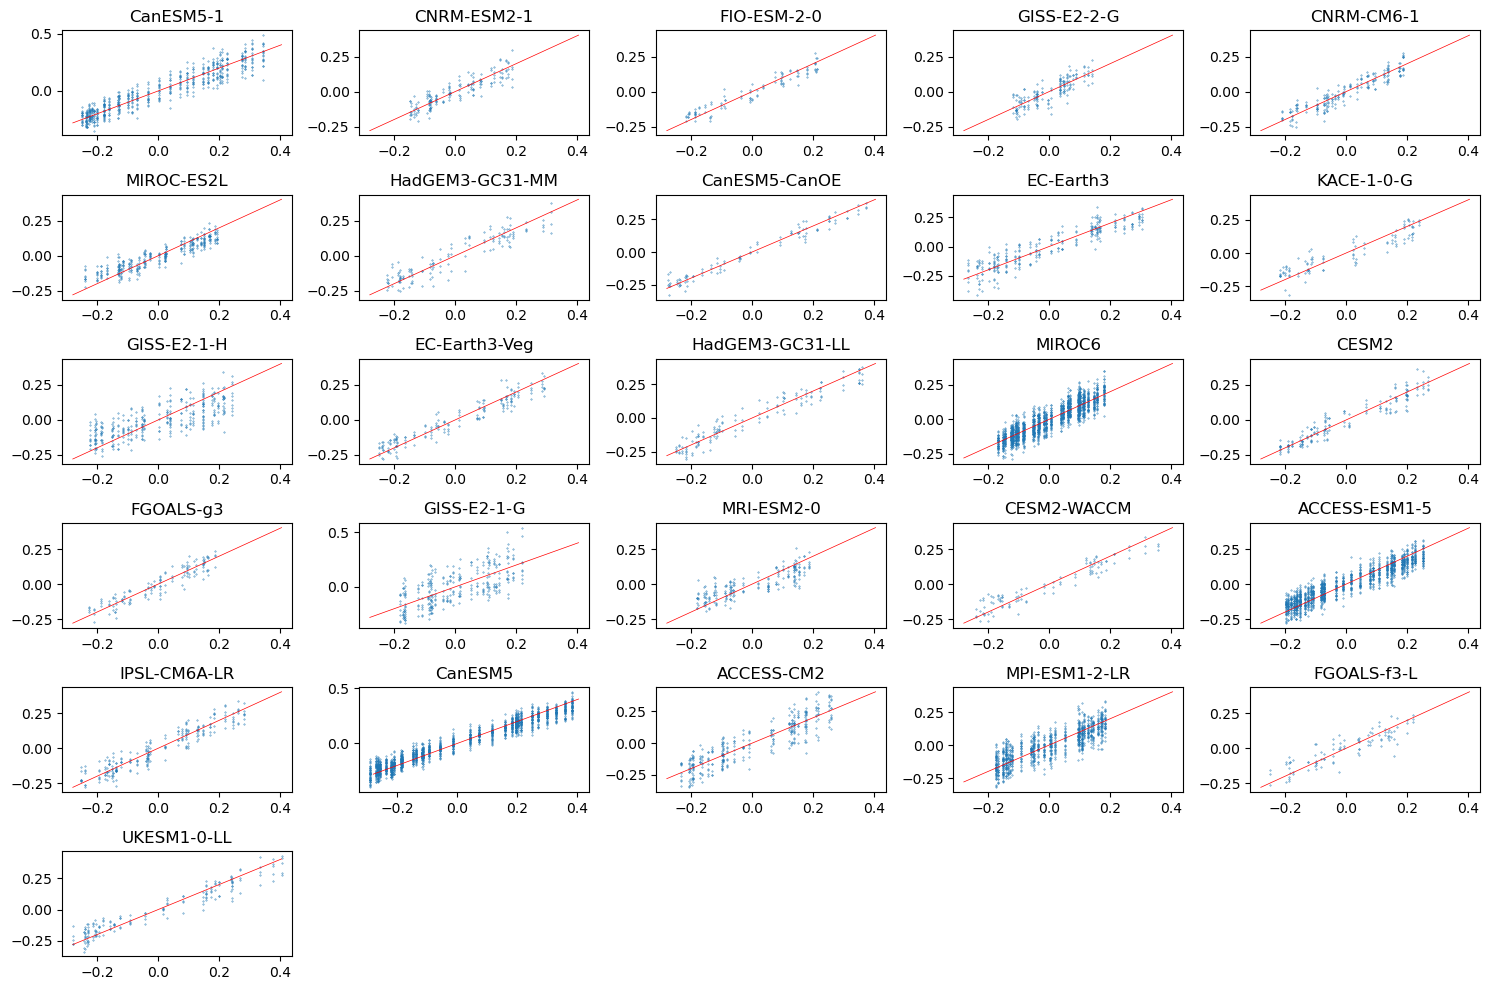

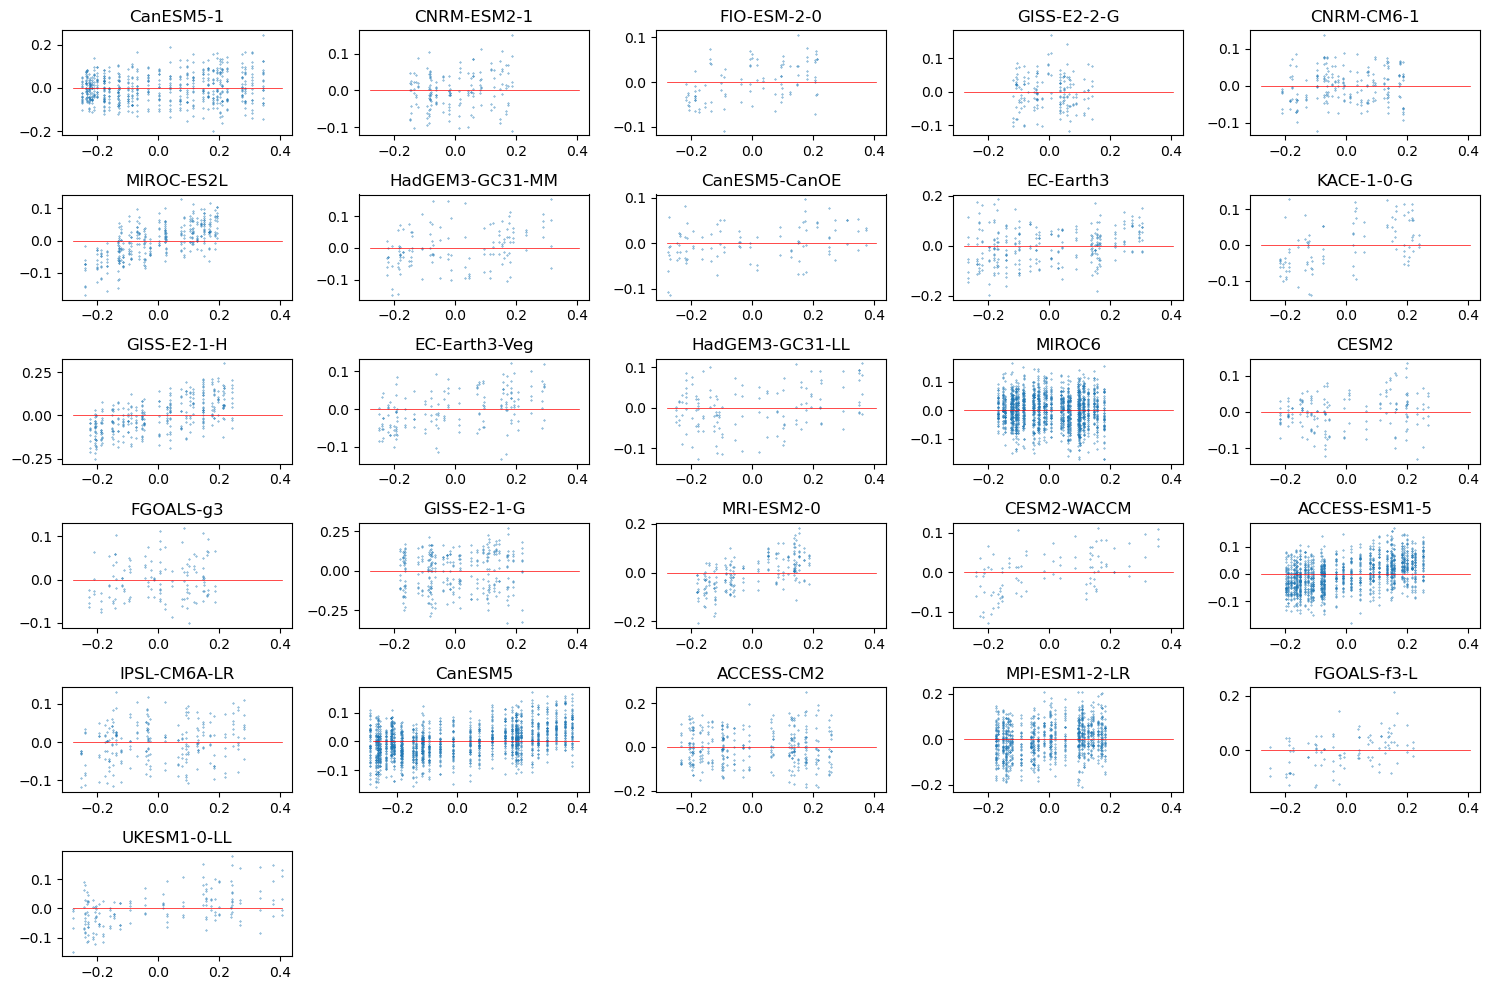

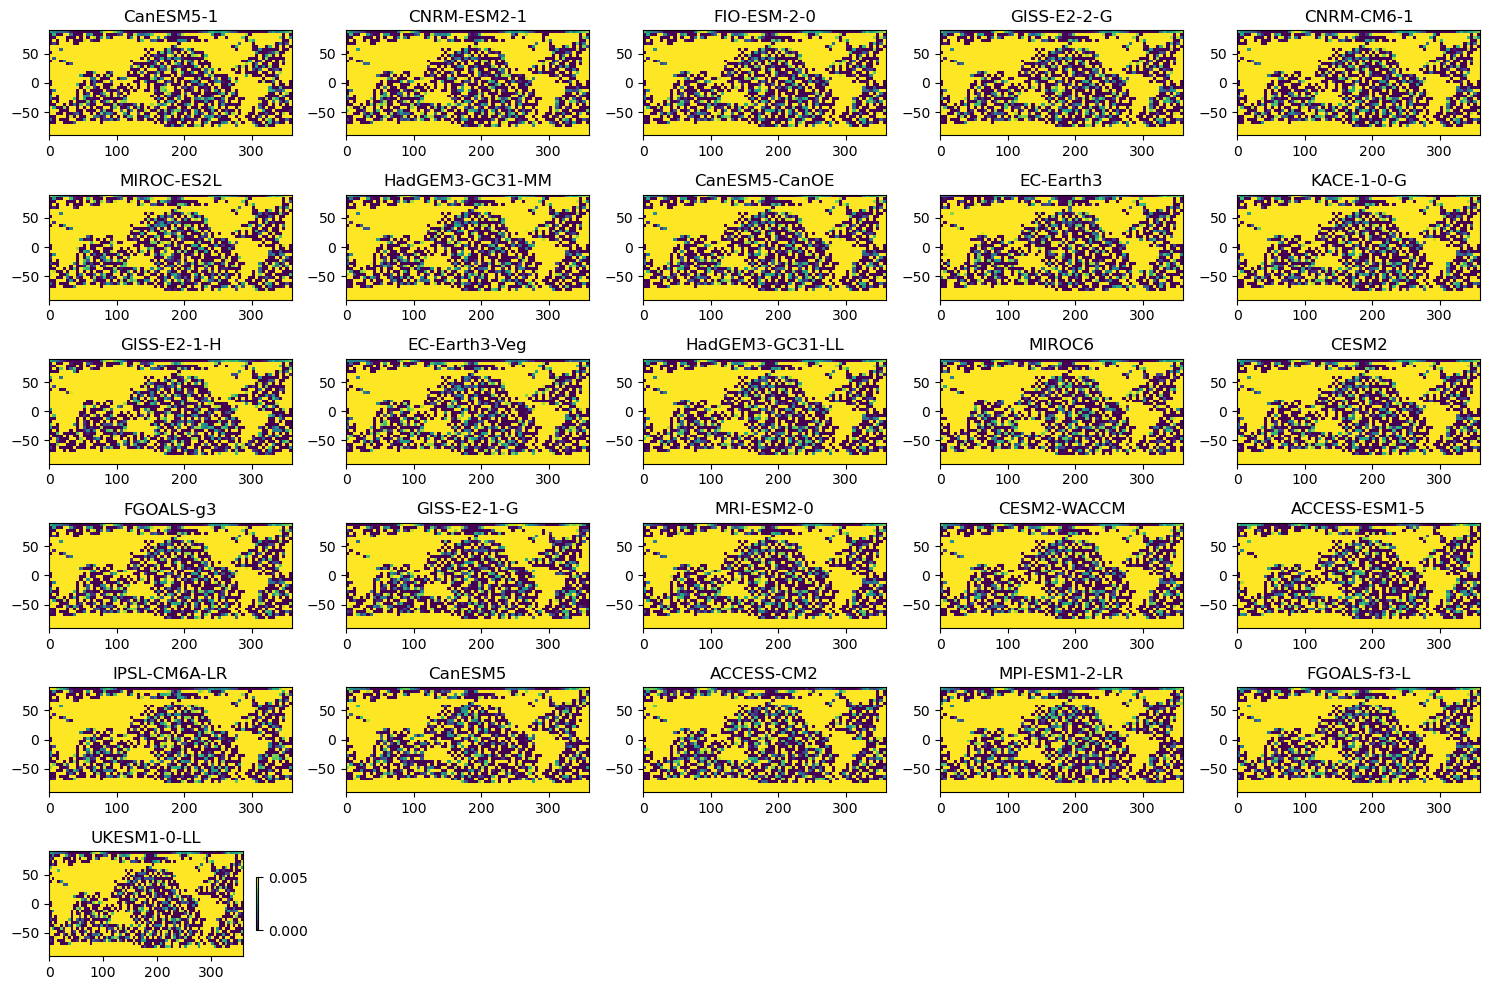

Cross validation: (0.1)
RMSE on model  CanESM5-1  :  0.004305363304490866
RMSE on model  CNRM-ESM2-1  :  0.002345954428324888
RMSE on model  FIO-ESM-2-0  :  0.0017583351578275537
RMSE on model  GISS-E2-2-G  :  0.0023210878987142028
RMSE on model  CNRM-CM6-1  :  0.0019328034045289768
RMSE on model  MIROC-ES2L  :  0.0027627284436395378
RMSE on model  HadGEM3-GC31-MM  :  0.0035708961206777955
RMSE on model  CanESM5-CanOE  :  0.0015208649020167265
RMSE on model  EC-Earth3  :  0.005035860282309034
RMSE on model  KACE-1-0-G  :  0.0041609119522587855
RMSE on model  GISS-E2-1-H  :  0.00922226726049477
RMSE on model  EC-Earth3-Veg  :  0.00252564374417065
RMSE on model  HadGEM3-GC31-LL  :  0.0027758141905453136
RMSE on model  MIROC6  :  0.002842826072286306
RMSE on model  CESM2  :  0.0022408322414483512
RMSE on model  FGOALS-g3  :  0.00196133022400147
RMSE on model  GISS-E2-1-G  :  0.015266563633844345
RMSE on model  MRI-ESM2-0  :  0.004019910535272834
RMSE on model  CESM2-WACCM  :  0.0029924811

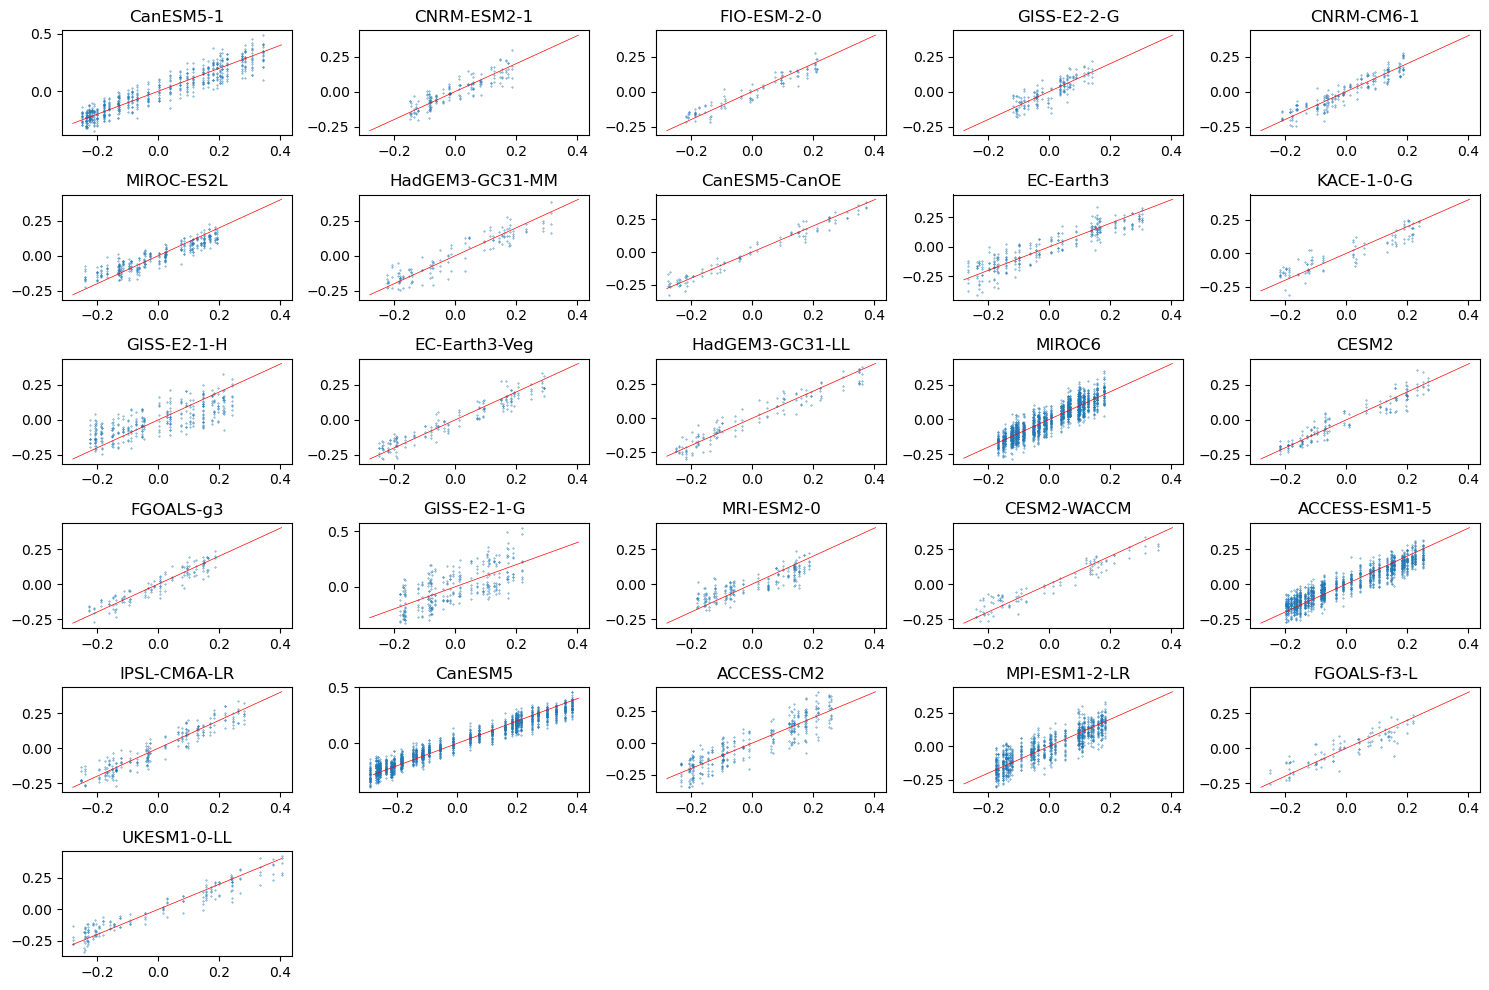

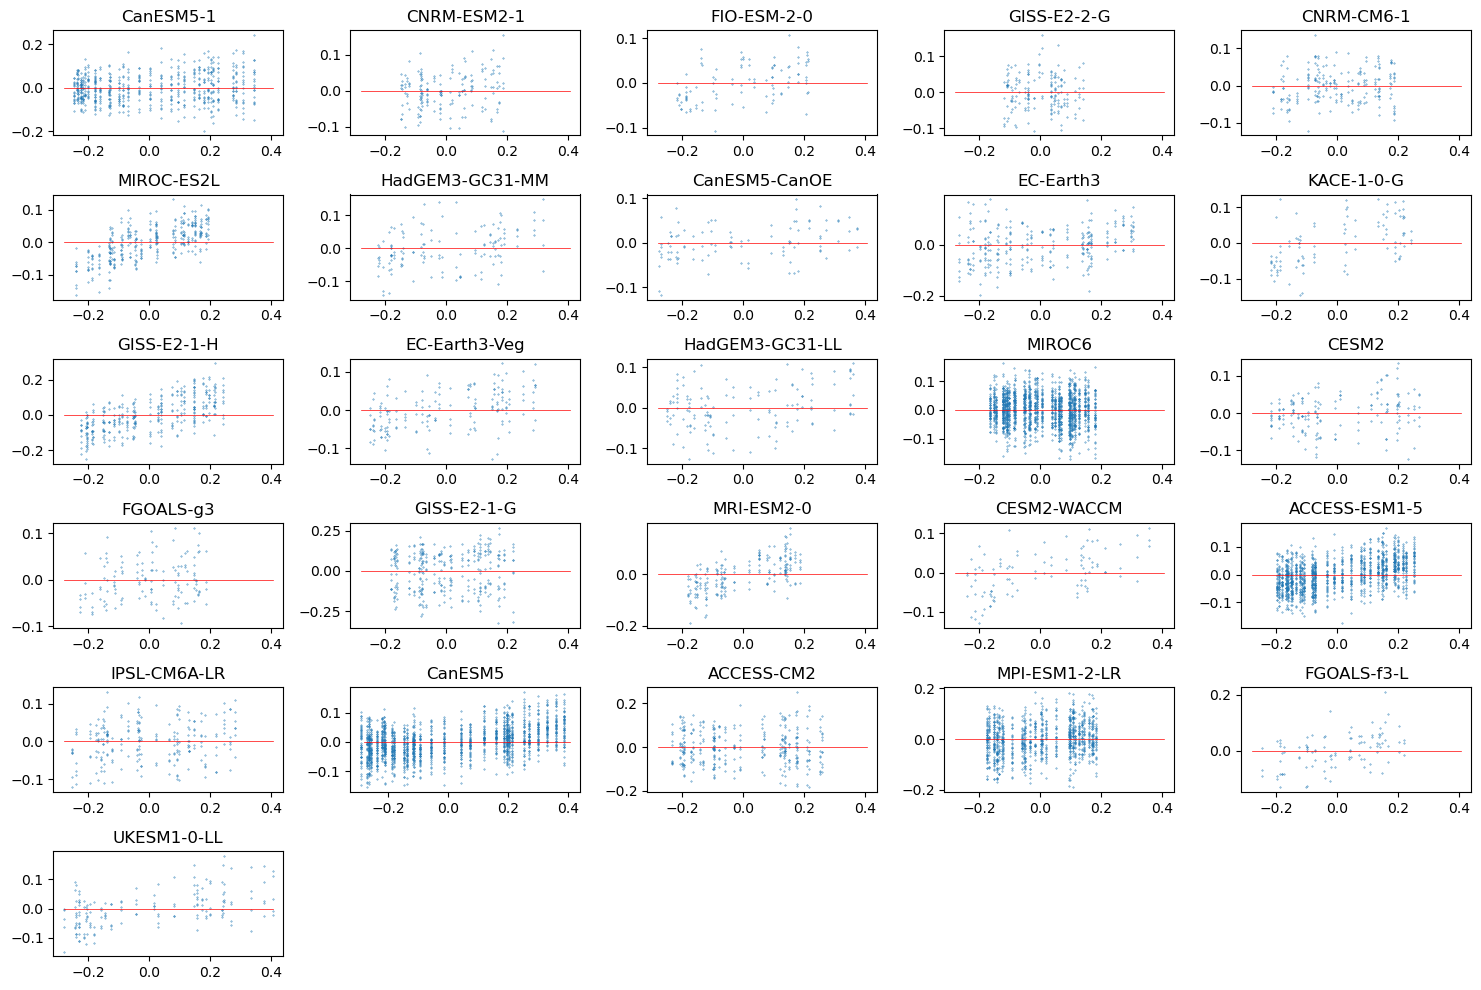

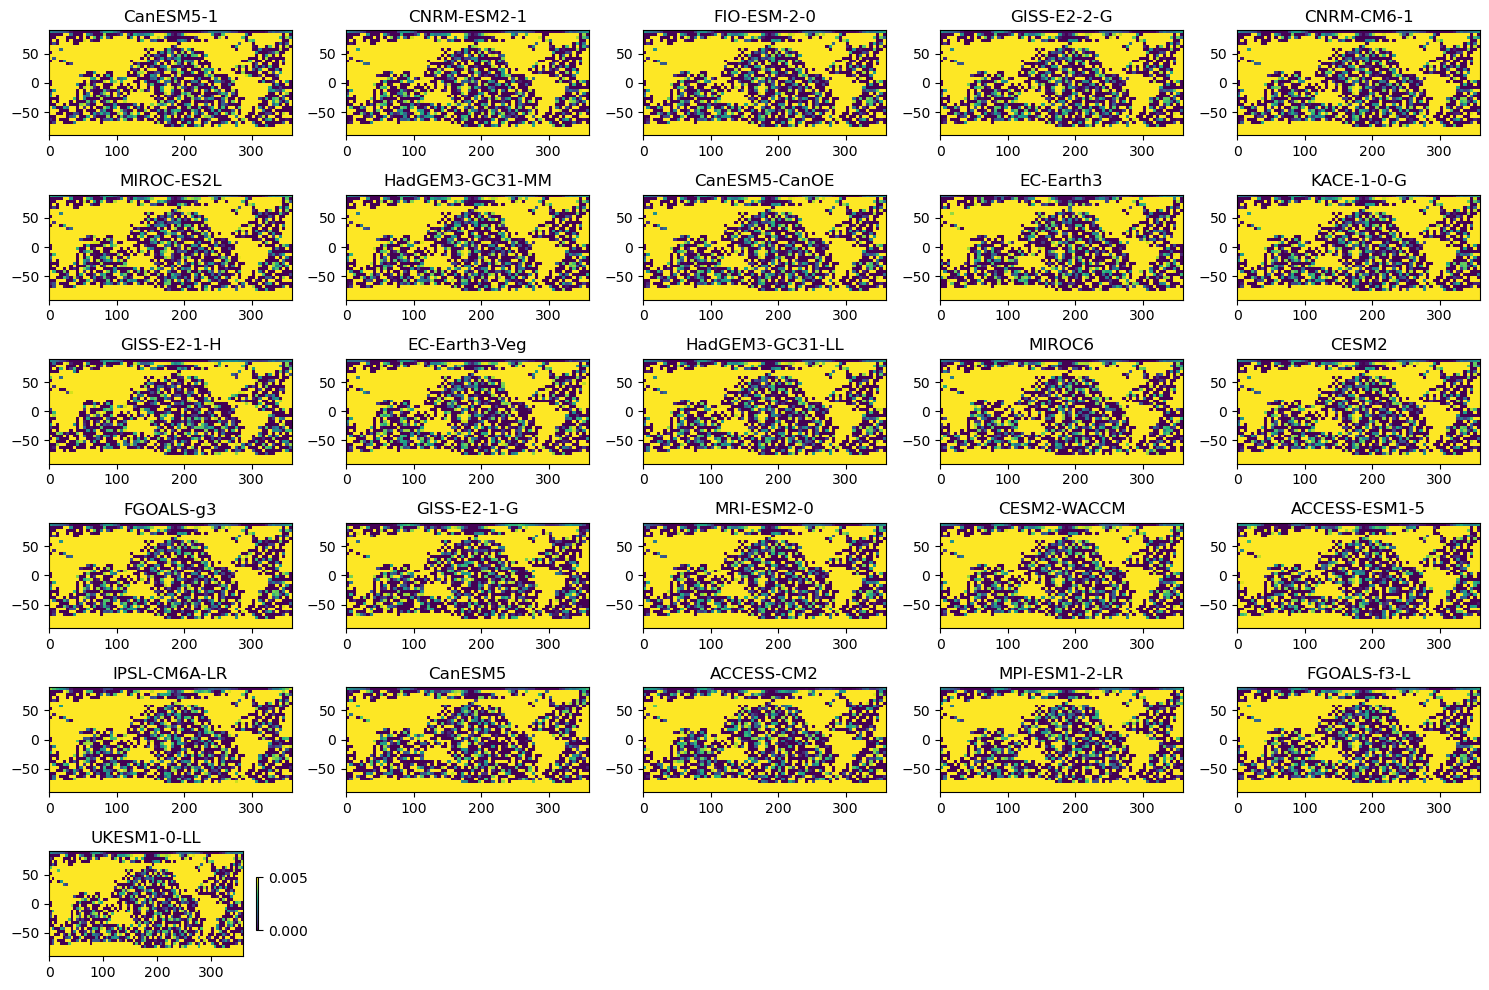

Cross validation: (0.5)
RMSE on model  CanESM5-1  :  0.00419933450089075
RMSE on model  CNRM-ESM2-1  :  0.002371494098023
RMSE on model  FIO-ESM-2-0  :  0.0017969801269433101
RMSE on model  GISS-E2-2-G  :  0.0019038168225493774
RMSE on model  CNRM-CM6-1  :  0.0019334467642452028
RMSE on model  MIROC-ES2L  :  0.002577865024274595
RMSE on model  HadGEM3-GC31-MM  :  0.0030574192459657795
RMSE on model  CanESM5-CanOE  :  0.0016454072677218436



KeyboardInterrupt



In [70]:
alpha_range = np.linspace(0.5, 1000, num=10)
lambda_range = np.linspace(0.01, 1000, num=20)

lambda_range = np.array([0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0])

with open('alpha_range.npy', 'wb') as f:
    np.save(f, alpha_range)

with open('lambda_range.npy', 'wb') as f:
    np.save(f, lambda_range)

# beta_robust, rmse, weights = cross_validation_loo(x_predictor,y_forced_response,variance_processed_ssp585,\
#                                                   grid_lon_size,grid_lat_size,\
#                                                   alpha_range,lambda_range,\
#                                                   nbEpochs=300,verbose=True)

beta_ridge, rmse_ridge = cross_validation_loo_ridge(x_predictor,y_forced_response,variance_processed_ssp585,\
                                              grid_lon_size,grid_lat_size,lambda_range)

In [ ]:
# leave_one_out_procedure(x_predictor,y_forced_response,variance_processed_ssp585,\
#               grid_lon_size,grid_lat_size,\
#               alpha_,lambda_,\
#               nbEpochs=1000,verbose=False)

## All models vs Observations

In [18]:
alpha_ = 0.5
lambda_ = 50
selected_models = list(dic_reduced_ssp585.keys())
beta_robust = train_robust_model(x_train,y_train,variance_processed_ssp585,\
                          grid_lat_size,grid_lat_size,\
                          selected_models,alpha_,lambda_,nbEpochs=1000,verbose=True)

Epoch  0 , loss= 15.481985092163086
Epoch  10 , loss= 5.0524516105651855
Epoch  20 , loss= 2.624539852142334
Epoch  30 , loss= 2.2308542728424072
Epoch  40 , loss= 2.238456964492798
Epoch  50 , loss= 2.1354150772094727
Epoch  60 , loss= 2.117658853530884
Epoch  70 , loss= 2.113415002822876
Epoch  80 , loss= 2.110539197921753
Epoch  90 , loss= 2.1084721088409424
Epoch  100 , loss= 2.107295036315918
Epoch  110 , loss= 2.1065468788146973
Epoch  120 , loss= 2.1060550212860107
Epoch  130 , loss= 2.105696678161621
Epoch  140 , loss= 2.1054294109344482
Epoch  150 , loss= 2.1052358150482178
Epoch  160 , loss= 2.1050944328308105
Epoch  170 , loss= 2.104987859725952
Epoch  180 , loss= 2.104907512664795
Epoch  190 , loss= 2.104846239089966
Epoch  200 , loss= 2.1047990322113037
Epoch  210 , loss= 2.104762554168701
Epoch  220 , loss= 2.104734182357788
Epoch  230 , loss= 2.1047117710113525
Epoch  240 , loss= 2.104694366455078
Epoch  250 , loss= 2.104680299758911
Epoch  260 , loss= 2.1046693325042725

In [19]:
# Compute anomalies of X
x_obs = sst[131:164,:,:]
x_obs[x_obs<-1e5] = float('nan')

# Compute mean over space
y_obs = np.nanmean(x_obs[:,:,:],axis=(1,2))

# coefficient factor
beta_softmax_test = beta_robust.detach().numpy().reshape(x_obs.shape[1]*x_obs.shape[2])
beta_softmax_test[beta_softmax_test>1e3] = 0.0

y_pred_softmax = np.dot(np.nan_to_num(x_obs).reshape(x_obs.shape[0],x_obs.shape[1]*x_obs.shape[2]),beta_softmax_test)
# y_pred_reg = np.dot(np.nan_to_num(x_obs).reshape(x_obs.shape[0],x_obs.shape[1]*x_obs.shape[2]),beta_reg_test)

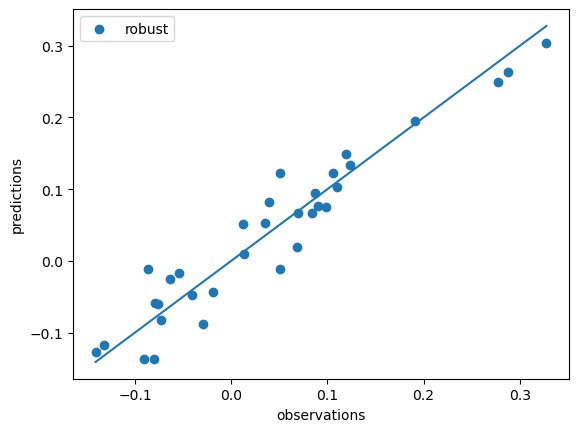

In [20]:
minx = np.min(y_obs)
maxx = np.max(y_obs)
x_tmp = np.linspace(minx,maxx,100)
y_tmp = x_tmp


fig, ax = plt.subplots()
ax.scatter(y_obs,y_pred_softmax,label='robust')
ax.plot(x_tmp,y_tmp)
ax.set_xlabel('observations')
ax.set_ylabel('predictions')
ax.legend()
plt.show()